##ME536 Fall '22 Final Project - Predicting the IMDB Score of movies using relavant features

Prepared by: Syed Fahad Saif - 245559


in this project, we try to predict the IMDB score which seems to be related to multiple features such as genres, box-office collection, etc.

We also try to see how it handles novel data.



Lets start with the imports..

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt
from google.colab import files
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
import tensorflow as tf
import sklearn
import math

Since our dataset contains the metadata of around 7,400 films but seperated on a yearly basis from 1980 to 2015 in the form of .json files, we need to preprocess the data and import it into a pandas dataframe.

# Preprocessing the data..

Note: Please add the Data.zip file on the Google Colab main directory

In [2]:
# Unzip the .zip file containing metadata
!unzip Data.zip -d movies

In [3]:
path = '/content/movies'
file_list = os.listdir(path)

# Initialize empty dataframe

df = pd.DataFrame()
df_list = []

# Import every year except 1980, 1981 and 2005 due to encoding issues

for filename in file_list:
    if filename.endswith('.json') and filename != "2005.json" and filename != "1980.json" and filename != "1981.json":
        file_path = os.path.join(path, filename)
        df_list.append(pd.read_json(file_path, encoding="utf-16"))

df = pd.concat(df_list, ignore_index=True)

# Drop uncessary columns and rearrage dataframe to visualise dataset

df =  df[['imdbID', 'Title', 'Language', 'Released','Rated', 'Runtime', 'Box_office', 'Genre', 'imdbRating']]

df

,imdbID,Title,Language,Released,Rated,Runtime,Box_office,Genre,imdbRating
0,tt0099785,Home Alone,English,16 Nov 1990,PG,103 min,"285,761,243","Comedy, Family",7.5
1,tt0099653,Ghost,English,13 Jul 1990,PG-13,127 min,"217,631,306","Drama, Fantasy, Romance",7.0
2,tt0099348,Dances with Wolves,"English, Sioux, Pawnee",21 Nov 1990,PG-13,181 min,"184,208,848","Adventure, Drama, Western",8.0
3,tt0100405,Pretty Woman,English,23 Mar 1990,R,119 min,"178,406,268","Comedy, Romance",6.9
4,tt0100758,Teenage Mutant Ninja Turtles,"English, French",30 Mar 1990,PG,93 min,"135,270,000","Action, Adventure, Comedy",6.7
...,...,...,...,...,...,...,...,...,...
7329,tt0495103,The Empire in Africa,"English, French",24 Jan 2006,N/A,87 min,None,Documentary,7.2
7330,tt0487156,In Her Line of Fire,English,21 Apr 2006,R,88 min,None,"Action, Drama",4.1
7331,tt0855484,Russell Brand's Got Issues,English,12 Sep 2006,N/A,23 min,None,"Comedy, Talk-Show",6.4
7332,tt0785003,Henry Rollins: Uncut from NYC,English,25 Mar 2006,N/A,85 min,None,Comedy,7.6


Okay, 7334 movies imported.

In [4]:
# Drop movies which contain any null data
df = df.dropna()
print(f'The movies we are gonna work with now are {len(df)}.')

The movies we are gonna work with now are 5149.


To process the numerical data in the dataset, such as Runtime, Release year, etc. we make it numeric.

In [5]:
df['Runtime'] = df['Runtime'].str[:-4]
df['Runtime'] = pd.to_numeric(df['Runtime'])

<ipython-input-5-0524868bc45a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Runtime'] = df['Runtime'].str[:-4]
<ipython-input-5-0524868bc45a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Runtime'] = pd.to_numeric(df['Runtime'])


In [6]:
df = df.dropna()

# Check again for null data

print(f'The number of movies we gonna work with is {len(df)}')

The number of movies we gonna work with is 5125


In [7]:
# Since almost all of the movies fell into these four rated categories of PG, PG-13, R, G, we only use these.

allowed_ratings = ['PG', 'PG-13', 'R', 'G']
df = df[df['Rated'].isin(allowed_ratings)]

print(f'The number of movies we gonna work with is {len(df)}')

The number of movies we gonna work with is 4396


In [8]:
# Since some data is not present in the dataset but named as a N/A string, remove that too

df = df[df.Released != "N/A"]
df = df[df.Rated != "N/A"]
df = df[df.Genre != "N/A"]
df = df[df.Box_office != "N/A"]

# Reset the index of the dataframe

df = df.reset_index(drop=True)


print(f'Finally!, the number of movies we gonna work with is {len(df)}')

Finally!, the number of movies we gonna work with is 4390


Convert the rest of the numerical data to numbers in the dataframe..

In [9]:
# Extact the year from the Released column 

df['Released'] = pd.to_datetime(df['Released']).dt.year
df['Box_office'] = df['Box_office'].str.replace(',', '').astype(float)

# Make sure the IMDB score of the movies is actually a number

df['imdbRating'] = df['imdbRating'].astype(float)

In the following section, we will perform **data analysis** to see which other features of the films affect it's score the most other than the genre in order to better predict the score.. (This is called **feature selection**)

To do that, we first drop the *Title* and *Language* columns as theres a no expected correlation between the Title of the film and it's score and most of the films are in English anyways.

In [10]:
 df = df[['Released', 'Rated', 'Runtime', 'Box_office', 'Genre', 'imdbRating']]

In [11]:
# Ordinal Encoding of the Rated column so that it could be processed

# rated = ['R', 'PG-13', 'PG', 'G']
rated = ['G', 'PG', 'PG-13', 'R']

ordi = OrdinalEncoder(categories=[rated])

ordi.fit(df[['Rated']])

df_encodedRated = pd.DataFrame(ordi.transform(df[['Rated']]))

df['Rated'] = df_encodedRated


<ipython-input-11-30f048247bdc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rated'] = df_encodedRated


Final pre-processed data looks like this..

In [12]:
df.head()

,Released,Rated,Runtime,Box_office,Genre,imdbRating
0,1990,1.0,103.0,285761243.0,"Comedy, Family",7.5
1,1990,2.0,127.0,217631306.0,"Drama, Fantasy, Romance",7.0
2,1990,2.0,181.0,184208848.0,"Adventure, Drama, Western",8.0
3,1990,3.0,119.0,178406268.0,"Comedy, Romance",6.9
4,1990,1.0,93.0,135270000.0,"Action, Adventure, Comedy",6.7


#Let's perform data analysis now

In [13]:
dfWithCandidateFeatures = df[['Released', 'Rated', 'Runtime', 'Box_office']]
clf = tree.DecisionTreeRegressor(max_depth = 10)
clf = clf.fit(np.array(dfWithCandidateFeatures), np.array(df['imdbRating']))

In [14]:
clf.feature_importances_
dfImportances = pd.DataFrame(clf.feature_importances_, columns = ['Importance Coefficients'])
dfWithCandidateFeaturesColumns = pd.DataFrame(np.array(dfWithCandidateFeatures.columns), columns = ['Feature Names'])

pd.concat([dfWithCandidateFeaturesColumns, dfImportances], axis = 1).sort_values(by=['Importance Coefficients'], ascending = False)

,Feature Names,Importance Coefficients
2,Runtime,0.462217
3,Box_office,0.326611
0,Released,0.158877
1,Rated,0.052295


In [15]:
# Multi hot encode genres for training purposes

df1 = df
df1["Genre"] = df1["Genre"].str.split(", ")
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df1["Genre"])
df2 = pd.concat([df1, pd.DataFrame(genres_encoded, columns=mlb.classes_)], axis=1)

In [16]:
# Defining functions which multi-hot encode box office and runtime that fall in certain ranges

# General range hot-encoder for runtime
def inRange(x, lowerLim, UpperLimExc):
  if(x >= lowerLim and x < UpperLimExc):
    return 1
  return 0

# Range hot-encoder for box-office collection

def lessThanEqToTenThousand(x):
  if(x <= 10000):
    return 1
  return 0

def bwTenThouAnd100Thousand(x):
  if(x > 10000 and x <= 100000):
    return 1
  return 0

def bw100ThouAndMill(x):
  if(x > 100000 and x <= 1000000):
    return 1
  return 0


def bwMillAnd100Mill(x):
  if(x > 1000000 and x <= 100000000):
    return 1
  return 0

def above100Mill(x):
  if(x > 100000000):
    return 1
  return 0

In [17]:
# Box_office encoding

df2 = pd.concat([df2, df2.Box_office.apply(lessThanEqToTenThousand).rename('lessThanEqToTenThousand')], axis = 1)
df2 = pd.concat([df2, df2.Box_office.apply(bwTenThouAnd100Thousand).rename('bwTenThouAnd100Thousand')], axis = 1)
df2 = pd.concat([df2, df2.Box_office.apply(bw100ThouAndMill).rename('bw100ThouAndMill')], axis = 1)
df2 = pd.concat([df2, df2.Box_office.apply(bwMillAnd100Mill).rename('bwMillAnd100Mill')], axis = 1)
df2 = pd.concat([df2, df2.Box_office.apply(above100Mill).rename('above100Mill')], axis = 1)

In [18]:
# Runtime encoding

df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [0, 75]).rename('lessThan75')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [75, 85]).rename('bw75And85')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [85, 95]).rename('bw85And95')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [95, 100]).rename('bw95And100')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [100, 105]).rename('bw100And105')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [105, 110]).rename('bw105And110')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [110, 115]).rename('bw110And115')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [115, 125]).rename('bw115And125')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [125, 135]).rename('bw125And135')], axis = 1)
df2 = pd.concat([df2, df2.Runtime.apply(inRange, args = [135, math.inf]).rename('greaterThanEqTo135')], axis = 1)

In [19]:
df2

,Released,Rated,Runtime,Box_office,Genre,imdbRating,Action,Adventure,Animation,Biography,...,lessThan75,bw75And85,bw85And95,bw95And100,bw100And105,bw105And110,bw110And115,bw115And125,bw125And135,greaterThanEqTo135
0,1990,1.0,103.0,285761243.0,"[Comedy, Family]",7.5,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1990,2.0,127.0,217631306.0,"[Drama, Fantasy, Romance]",7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1990,2.0,181.0,184208848.0,"[Adventure, Drama, Western]",8.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1990,3.0,119.0,178406268.0,"[Comedy, Romance]",6.9,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1990,1.0,93.0,135270000.0,"[Action, Adventure, Comedy]",6.7,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385,2006,3.0,82.0,12644.0,[Drama],5.6,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4386,2006,3.0,105.0,12737.0,"[Documentary, Music]",7.5,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4387,2007,3.0,88.0,4350.0,[Drama],6.4,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4388,2006,3.0,102.0,3602.0,[Drama],3.8,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Data clustering

In [20]:
# Generate dataframe df3 which only contain the genre columns
df3 = df2 [['Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']]

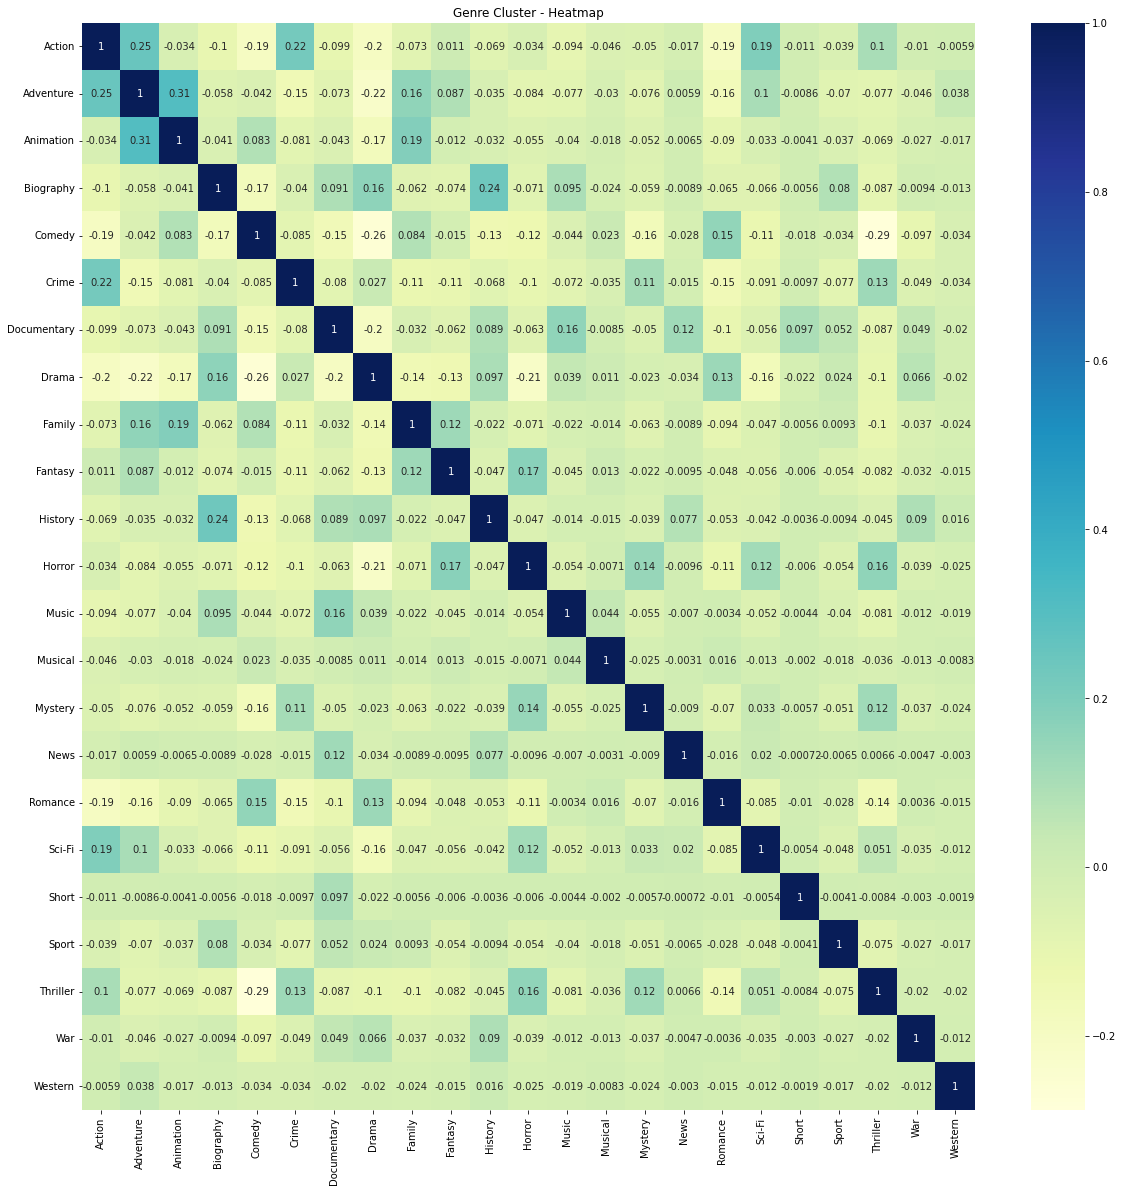

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(df3.corr(), annot=True, cmap='YlGnBu')
plt.title("Genre Cluster - Heatmap")
plt.show()

Now select a few of the rare genre combinations as novel data i.e. the data that the model won't see

In [22]:
# Choose movies who have the genres Comedy, Thriller and Comedy, Drama as novel data

# Find indices of the movies where these genre combinations appear
x = []
for i in range(len(df2)):
  x.append(((df2.Comedy[i] and df2.Drama[i]) == 1) or ((df2.Comedy[i] and df2.Thriller[i]) == 1))

# Generate copy of dataframe named df4 which contain only "normal data", i.e the data that the predicting model is supposed to train on
list(df2[x].index)
df4 = df2.copy()

# dfNovel dataframe only contains novel data
dfNovel = df2[x].copy()
df4.drop(index = list(df2[x].index), inplace = True)


df4 = df4.reset_index(drop = True)
dfNovel = dfNovel.reset_index(drop = True)

In [23]:
print(f'The number of normal movies are {len(df4)}')
print(f'The number of novel movies are {len(dfNovel)}')

The number of normal movies are 3713
The number of novel movies are 677


In [24]:
# Assign the "normal data" dataframe back to the dataframe we were working on
df2 = df4

#Creating IMDB prediction model

In [25]:
dfNovel.columns

Index(['Released', 'Rated', 'Runtime', 'Box_office', 'Genre', 'imdbRating',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western', 'lessThanEqToTenThousand',
       'bwTenThouAnd100Thousand', 'bw100ThouAndMill', 'bwMillAnd100Mill',
       'above100Mill', 'lessThan75', 'bw75And85', 'bw85And95', 'bw95And100',
       'bw100And105', 'bw105And110', 'bw110And115', 'bw115And125',
       'bw125And135', 'greaterThanEqTo135'],
      dtype='object')

In [26]:
# Input array to our training model, containing encoded features: Genre, Box-office collection and Runtime of film

X = np.array(df2[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western', 'lessThanEqToTenThousand',
       'bwTenThouAnd100Thousand', 'bw100ThouAndMill', 'bwMillAnd100Mill',
       'above100Mill', 'lessThan75', 'bw75And85', 'bw85And95', 'bw95And100',
       'bw100And105', 'bw105And110', 'bw110And115', 'bw115And125',
       'bw125And135', 'greaterThanEqTo135']])

# IMDB score of film

y = np.array(df2['imdbRating'])

# Features of novel data: Genre, Box-office collection and Runtime of film

xNovel = np.array(dfNovel[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western', 'lessThanEqToTenThousand',
       'bwTenThouAnd100Thousand', 'bw100ThouAndMill', 'bwMillAnd100Mill',
       'above100Mill', 'lessThan75', 'bw75And85', 'bw85And95', 'bw95And100',
       'bw100And105', 'bw105And110', 'bw110And115', 'bw115And125',
       'bw125And135', 'greaterThanEqTo135']])

# IMDB score of film 
yNovel = np.array(dfNovel['imdbRating'])

In [27]:
# Train test split the normal data with a 70-30 split.

xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X, y , random_state = 1, train_size = 0.3)

In [28]:
# Define activation function for last layer of model

def mySigmoid(x):
    output = tf.sigmoid(x)
    output._keras_logits = x
    return 10 * output

In [29]:
# Model architecture of main neural network

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 38, activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = mySigmoid),
])

# Adam optimizer with a learning rate of 0.0005

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compile model with the mean squared error loss function
model.compile(optimizer = adam, loss = 'mse')

In [30]:
# Train the model with 50 epochs

history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest), epochs = 50)

Epoch 1/50
35/35 [==============================] - 2s 22ms/step - loss: 1.8545 - val_loss: 1.3616
Epoch 2/50
35/35 [==============================] - 1s 15ms/step - loss: 1.3272 - val_loss: 1.1056
Epoch 3/50
35/35 [==============================] - 1s 15ms/step - loss: 1.1195 - val_loss: 1.0093
Epoch 4/50
35/35 [==============================] - 1s 15ms/step - loss: 1.0419 - val_loss: 0.9540
Epoch 5/50
35/35 [==============================] - 1s 16ms/step - loss: 1.0116 - val_loss: 0.9140
Epoch 6/50
35/35 [==============================] - 1s 18ms/step - loss: 0.9588 - val_loss: 0.8878
Epoch 7/50
35/35 [==============================] - 1s 15ms/step - loss: 0.8827 - val_loss: 0.8712
Epoch 8/50
35/35 [==============================] - 1s 21ms/step - loss: 0.8820 - val_loss: 0.8555
Epoch 9/50
35/35 [==============================] - 0s 14ms/step - loss: 0.8399 - val_loss: 0.8415
Epoch 10/50
35/35 [==============================] - 1s 16ms/step - loss: 0.8321 - val_loss: 0.8345
Epoch 11/

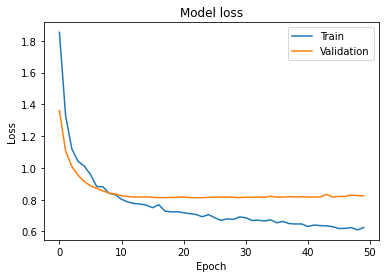

In [31]:
# Visualise the results

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Training an Autoencoder for Novelty Detection

In [42]:
latent_dim = 20 

class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(38, activation='relu'),
      tf.keras.layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(38, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [43]:
# Adam optimizer and mean squared error loss function

autoencoder.compile(optimizer='adam', loss='mse')
# Fitting on the normal data as train data and novel data as validation data

autoencoder.fit(X, X,
                epochs=250,
                shuffle=True,
                validation_data=(xNovel, xNovel))

Epoch 1/250
117/117 [==============================] - 1s 4ms/step - loss: 0.1583 - val_loss: 0.0751
Epoch 2/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0631
Epoch 3/250
117/117 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0533
Epoch 4/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 5/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0399
Epoch 6/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.0392
Epoch 7/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0370
Epoch 8/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0392
Epoch 9/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.0395
Epoch 10/250
117/117 [==============================] - 0s 3ms/step - loss: 0.0117 - val_lo

As expected, loss is practically zero for trained data as it can easily reconstruct it however the loss is higher for novel data which is the validation data showing it can detect novelty

## Let's if the autoencoder correctly detects novel data

In [68]:
# Mix all movies which are novel and normal for demonstration

mixedData = np.vstack((X, xNovel))
np.random.shuffle(mixedData)
mixedData


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Since discrepency between autoencoder input and output can be used to correctly classify data as novel or normal most of the time we can conclude it as being accurate

#Demonstration

Let's first use the autoencoder to detect some novel data

In [69]:
novel_data_prediction = []
normal_data = []


# take first 20 rows of mixed movies to demonstrate

for data in mixedData[0:20,:]:
  # if the discrerpancy between the sum of differences between input and reconstructed input is greater than 0.1, it is a novel movie
  
  predictedNovel = abs((autoencoder.predict(np.expand_dims(data, axis = 0))[0] - np.expand_dims(np.array(data), axis = 0)[0]).sum()) > 0.1
  if(predictedNovel):
    novel_data_prediction.append(data)
  else:
    normal_data.append(data)
    


1/1 [==============================] - 0s 19ms/step


In [78]:
# Check if the novel data prediction is actually true by seeing if it satisfies the genre condition

for i in range(len(novel_data_prediction)):
  if (novel_data_prediction[i][4] == 1 and novel_data_prediction[i][7] == 1) or (novel_data_prediction[i][4] == 1 and novel_data_prediction[i][20] == 1):
    print("This movie is actually novel and the model also predicted so!")
  else:

    # If theres any other film that is predicted to be novel but actually isn't, is an error due to lack of optimization of autoencoder

    print("This movie is actually not novel but predicted so.")



This movie is actually novel and the model also predicted so!
This movie is actually novel and the model also predicted so!
This movie is actually novel and the model also predicted so!


Let's run it through our IMDB score predictor, shall we?

In [79]:
classify_novel_data = []
for i in range(len(novel_data_prediction)):
  predsOnNovel = model.predict(np.expand_dims(novel_data_prediction[i], axis = 0))

  # Whatever the model has predicted as novel, if the predicted IMDB score is greater than 6, it's a good novel film otherwise its bad.
  
  if (predsOnNovel[0]>6):
    classify_novel_data.append(f'The movie is good novel with an IMDB score of {predsOnNovel[0]}')
  else:
    classify_novel_data.append(f'The movie is bad novel with an IMDB score of {predsOnNovel[0]}')
  

1/1 [==============================] - 0s 19ms/step


In [80]:
classify_novel_data

['The movie is good novel with an IMDB score of [6.202622]',
 'The movie is bad novel with an IMDB score of [5.7943525]',
 'The movie is bad novel with an IMDB score of [5.7485986]']

The novel's data features can be checked here:

In [77]:
df_novel_data  = pd.DataFrame(data = novel_data_prediction, columns=['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western', 'lessThanEqToTenThousand',
       'bwTenThouAnd100Thousand', 'bw100ThouAndMill', 'bwMillAnd100Mill',
       'above100Mill', 'lessThan75', 'bw75And85', 'bw85And95', 'bw95And100',
       'bw100And105', 'bw105And110', 'bw110And115', 'bw115And125',
       'bw125And135', 'greaterThanEqTo135'])
df_novel_data

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,lessThan75,bw75And85,bw85And95,bw95And100,bw100And105,bw105And110,bw110And115,bw115And125,bw125And135,greaterThanEqTo135
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


Let's check how the predictor works on normal data as well..


In [76]:
for i in range(10):

  # Test 10 movies from the normal data's validation set
  
  predsOnNormal = model.predict(np.expand_dims(xTest[i], axis = 0))
  print(f'The predicted IMDB score is {np.round_(predsOnNormal[0], decimals=1)} while having a true value of {yTest[i]}')

1/1 [==============================] - 0s 76ms/step
The predicted IMDB score is [6.7] while having a true value of 6.5
1/1 [==============================] - 0s 80ms/step
The predicted IMDB score is [7.5] while having a true value of 8.0
1/1 [==============================] - 0s 72ms/step
The predicted IMDB score is [6.3] while having a true value of 7.6
1/1 [==============================] - 0s 45ms/step
The predicted IMDB score is [7.] while having a true value of 7.6
1/1 [==============================] - 0s 41ms/step
The predicted IMDB score is [7.3] while having a true value of 7.4
1/1 [==============================] - 0s 35ms/step
The predicted IMDB score is [6.4] while having a true value of 6.6
1/1 [==============================] - 0s 32ms/step
The predicted IMDB score is [7.4] while having a true value of 7.6
1/1 [==============================] - 0s 32ms/step
The predicted IMDB score is [5.1] while having a true value of 5.5
1/1 [==============================] - 0s 43ms/st

Pretty good!